In [60]:
from __future__ import annotations

# Import the ChatGroq class from the langchain_groq package
from langchain_groq import ChatGroq
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

from typing import TypedDict, List, Annotated
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send

In [61]:
from dotenv import load_dotenv
load_dotenv()

True

In [62]:
class Task(BaseModel):
    id: str
    title: str
    brief: str = Field(description="What to Cover in the blog post")

In [63]:
class Plan(BaseModel):
    blog_title: str
    tasks: List[Task]
    

In [64]:
import operator

class State(TypedDict):
    topic: str
    plan: Plan
    task: Task  # for individual worker execution
    sections: Annotated[List[str], operator.add]
    final: str

In [65]:
llm = ChatGroq(model="llama-3.3-70b-versatile")


In [66]:
llm.invoke("Good Morning")

AIMessage(content='Good morning! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 37, 'total_tokens': 48, 'completion_time': 0.009949065, 'completion_tokens_details': None, 'prompt_time': 0.004222011, 'prompt_tokens_details': None, 'queue_time': 0.047909885, 'total_time': 0.014171076}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_68f543a7cc', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c2e2e-7b0c-75a1-ade7-cb62d2d84909-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 37, 'output_tokens': 11, 'total_tokens': 48})

In [67]:
def orchestrator(state: State):
    plan = llm.with_structured_output(Plan).invoke(
        [
            SystemMessage(
                content=(
                    "You are an experienced technical writer who creates clear, friendly, and engaging blog plans. "
                    "Your audience includes recruiters, hiring managers, and professionals who prefer concise, readable content. "
                    "Avoid jargon-heavy language. Focus on clarity, real-world relevance, and logical flow."
                )
            ),
            HumanMessage(
                content=(
                    f"Create a blog outline with 6–7 well-structured sections on the topic below.\n\n"
                    f"Topic: {state['topic']}\n\n"
                    "Each section should:\n"
                    "- Have a clear, engaging title\n"
                    "- Include a short 1–2 sentence description\n"
                    "- Be written in a friendly, conversational tone\n"
                    "- Emphasize practical insights and real-world value\n\n"
                    "The outline should feel approachable, professional, and easy to skim."
                )
            )
        ]
    )
    return {"plan":plan}
    

In [69]:
def task_distributor(state: State):
    """
    Dynamically creates one worker per task.
    The number of workers equals the number of sections in the plan.
    """

    tasks = state["plan"].tasks

    # Create one Send event per task
    sends = [
        Send(
            "section_writer",  # name of the worker node
            {
                "topic": state["topic"],
                "task": task,  # pass individual task
            },
        )
        for task in tasks
    ]

    return {"__send__": sends}

In [70]:
def section_writer(state: State):
    task = state["task"]

    content = llm.invoke(
        [
            SystemMessage(
                content=(
                    "You are a professional technical blog writer. "
                    "Write clean markdown. Use proper headings (##), short paragraphs, "
                    "bullet points where helpful, and keep it readable."
                )
            ),
            HumanMessage(
                content=(
                    f"Write a blog section titled: {task.title}\n\n"
                    f"Brief: {task.brief}\n\n"
                    "Return only markdown content."
                )
            ),
        ]
    )

    # Ensure section starts with proper heading
    section_md = f"## {task.title}\n\n{content.content.strip()}\n"

    return {"sections": [section_md]}



In [71]:
from pathlib import Path

def markdown_compiler(state: State):
    blog_title = state["plan"].blog_title
    sections = state["sections"]

    final_markdown = f"# {blog_title}\n\n"

    # Optional intro line
    final_markdown += "_A practical guide for professionals and hiring managers._\n\n"

    final_markdown += "\n".join(sections)
    
    file_path = blog_title.lower().replace(" ", "_").replace(":", "").replace("'", "") + ".md"
    Path(file_path).write_text(final_markdown, encoding="utf-8")

    return {"final": final_markdown}


In [72]:
builder = StateGraph(State)

builder.add_node("orchestrator", orchestrator)
builder.add_node("task_distributor", task_distributor)
builder.add_node("section_writer", section_writer)
builder.add_node("markdown_compiler", markdown_compiler)

builder.add_edge(START, "orchestrator")
builder.add_edge("orchestrator", "task_distributor")
builder.add_edge("task_distributor", "section_writer")


builder.add_edge("section_writer", "markdown_compiler")
builder.add_edge("markdown_compiler", END)

graph = builder.compile()


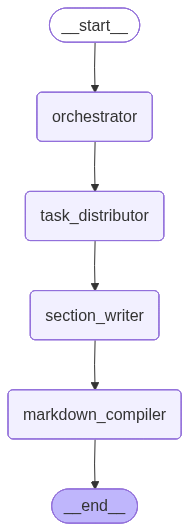

In [73]:
graph

In [74]:
new_md = graph.invoke({"topic": "Agentic AI"})

KeyError: 'task'